# MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

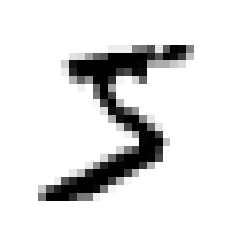

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)  # need to reshape to plot! X[0] row has 28x28 features (784 pixels)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [9]:
y[0]

'5'

In [10]:
# labels are strings! recast as integers
import numpy as np

y = y.astype(np.uint8)

In [7]:
# split off test set! MNIST already has this split defined, so just implement it

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier
Start with 5! Classes become 5 and not-5

In [8]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

guessed correctly!

# Performance Measures
## Measuring Accuracy Using Cross-Validation

In [11]:
# custom cross-validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/Users/ericfiegel/ml/env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

the above classifier seems to do a good job, but it's deceiving! see below, how a "classifier" that predicts all 0s will give a similarly "good" result. it's just that about 90% of the images are not-5.

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Above shows
[[true negative, false positives],
[false negatives, true positives]]. Perfect classifier would have 0s in off-diagonals

In [16]:
y_train_perfect_predictions = y_train_5 # pretend it was perfect
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

visualize tradeoff

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

above comparison shows that increasing threshold decreases recall!

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

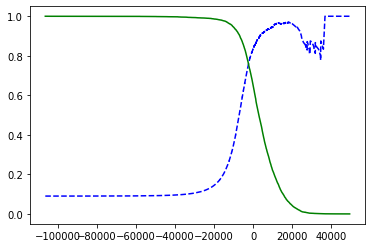

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [26]:
# choose a threshold that gives you the precision you want! could likewise choose for recall

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439594

In [27]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## The ROC Curve
Receiver operatinc characteristic (ROC) curve, plots true positive rate (AKA recall) against the false postive rate. FPR is ratio of negative instances incorrectly classified as positive, equals 1 - true negative rate (TNR, AKA specificity) which is ratio of negative instances correctly classified as negative. ROC plots sesitivity (recall) vs (1-specificity).

<function matplotlib.pyplot.show(*args, **kw)>

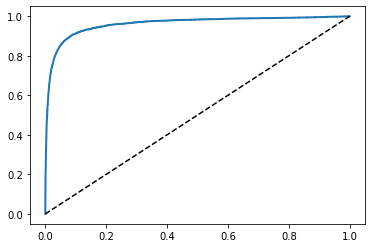

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # dashed diagonal: represents the ROC curve of a purely random classifier!
    
plot_roc_curve(fpr, tpr)
plt.show

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

y_scores_forest = y_probas_forest[:,1] # score = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

<function matplotlib.pyplot.show(*args, **kw)>

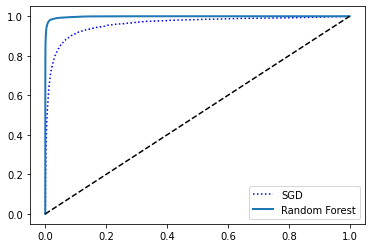

In [33]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [35]:
y_train_pred_50_perc = (y_scores_forest > 0.5)
precision_score(y_train_5, y_train_pred_50_perc)

0.9905083315756169

In [36]:
recall_score(y_train_5, y_train_pred_50_perc)

0.8662608374838591

# Multiclass Classification

In [37]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # not y_train_5!
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Under the hood, sklearn used OvO to train 45 binary classifiers and selected the class that won the most duels.

In [38]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [39]:
np.argmax(some_digit_scores)

5

In [40]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

change the default setting for OvO or OvR

In [41]:
# too slow! not running
# from sklearn.multiclass import OneVsRestClassifier
# ovr_clf = OneVsRestClassifier(SVC())
# ovr_clf.fit(X_train, y_train)

In [42]:
# ovr_clf.predict([some_digit])

In [43]:
# len(ovr_clf.estimators_)

In [44]:
# a different classifier
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [45]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

gets it wrong for this instance! thinks class 3 with second choice as correct answer class 5

In [46]:
# takes some time
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

good, but improves with input scaling!

In [47]:
# takes some time
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [48]:
# takes some time
# y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

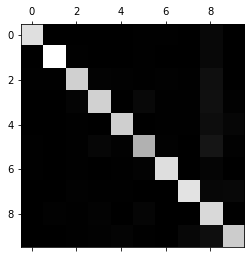

In [49]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

normalize by number of instances in each class and set diagonal to 0! This will plot only errors and see which mistakes are most common for the classifier.

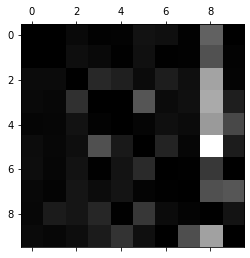

In [50]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

above, see that most frequent error is predicting 5s as 8s (rows = actuals, cols = predictions). notice that 8's col is bright, indicating that other classes get misclassified as 8s; 8's row, however, is dark, indicating that true 8s are generally classified correctly. also note: the matrix isn't necessarily symmetrical! also note: in this case, we can see that 3s and 5s often get confused (in both directions)

# Multilabel Classification
The example below is used to identify if an image is large (7, 8, or 9) and if it is odd

In [51]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

In [52]:
# takes a bit of time to run
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

# Multioutput Classification (Multioutput-Multiclass Classification)
Generalization of multilabel classification where each label can be multiclass (i.e. it can have more than two possible values)

In [55]:
# Add noise to an image and then clean it using classification
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

some_index = 0
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
# plot

# Exercises
## 1.
Get over 97% accuracy on the test set. Hint: KNeighborsClassifier works pretty well. Find the a good set of hyperparameters using a grid search on weights and n_neighbors. Note that the code below take a smaller sample of the data before processing! This gives a worse result but is much faster to run and experiment with. As a result, I never converge on the 97% but am confident that a larger test set could get it there.

In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
import pandas as pd

# create a subset sample of the data. note that this is a quick approach! should ideally account for each class %
data = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1, sort=False)
sample = data.sample(frac=.1)
X_sample = sample.iloc[:,:-1]
y_sample = sample.iloc[:,-1].astype(np.uint8)

knn_clf = KNeighborsClassifier()

param_grid = [
    {'weights':['uniform', 'distance'], 'n_neighbors': range(4, 8)},
]

grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_sample, y_sample)
grid_search.best_params_
grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

# code to start with a random search if desired
# rand_search = RandomizedSearchCV(knn_clf, param_grid, n_iter=2, scoring='accuracy')
# rand_search.fit(X_sample, y_sample)
# rand_search.best_params_
# rand_search.best_estimator_
# cvres = rand_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(mean_score, params)

0.9304278135951115 {'n_neighbors': 4, 'weights': 'uniform'}
0.9395702630061119 {'n_neighbors': 4, 'weights': 'distance'}
0.9331423034726591 {'n_neighbors': 5, 'weights': 'uniform'}
0.9374282015805172 {'n_neighbors': 5, 'weights': 'distance'}
0.9292851604581044 {'n_neighbors': 6, 'weights': 'uniform'}
0.9371421403939086 {'n_neighbors': 6, 'weights': 'distance'}
0.9297136094726716 {'n_neighbors': 7, 'weights': 'uniform'}
0.9328565483647866 {'n_neighbors': 7, 'weights': 'distance'}


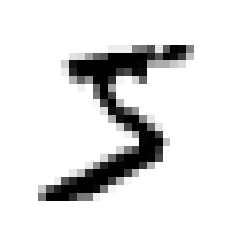

In [52]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)  # need to reshape to plot! X[0] row has 28x28 features (784 pixels)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

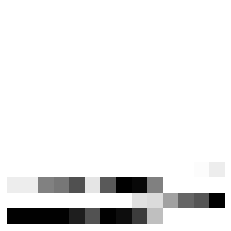

In [46]:
dim = 14
smaller_digit = np.resize(some_digit,(dim,dim))
smaller_digit_image = smaller_digit.reshape(dim,dim)

plt.imshow(smaller_digit_image, cmap="binary")
plt.axis("off")
plt.show()

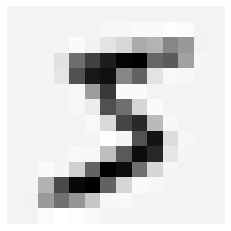

In [47]:
from PIL import Image
dim = 14

im = Image.fromarray(some_digit_image)
# some_digit_image = im.reshape(28,28)
smaller_im = im.resize((dim, dim))

smaller_digit_image = np.asarray(smaller_im)

plt.imshow(smaller_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
from PIL import Image
def my_resize(x, original_dim, new_dim):
    sq = x.reshape(original_dim, original_dim)
    im = Image.fromarray(sq)
    new_im = im.resize((new_dim, new_dim))
    new_x = np.asarray(new_im).reshape(new_dim * new_dim,)
    return new_x

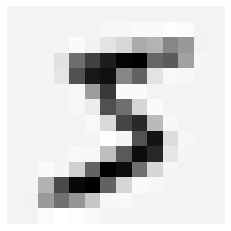

In [8]:
# y = y.astype(np.uint8)
# X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
import numpy as np
X_copy = np.copy(X)
X_new = []

# for i in range(len(X_new)):
for i in range(10):
    X_new.append(my_resize(X_copy[i], 28, 14))

X_new = np.asarray(X_new)

# X_new
some_digit = X_new[0]
some_digit_image = some_digit.reshape(14,14)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [34]:
import numpy as np
X_copy = np.copy(X)
X_new = []

for i in range(len(X_copy)):
    X_new.append(my_resize(X_copy[i], 28, 14))

X_train_new, X_test_new, y_train_new, y_test_new = X_new[:60000], X_new[60000:], y[:60000], y[60000:]

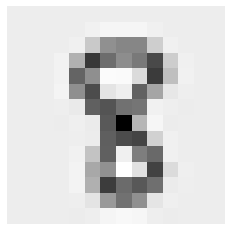

In [35]:
some_digit = X_new[50001]
some_digit_image = some_digit.reshape(14,14)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [37]:
# np.isnan(X_new).sum()
# np.isinf(X_new).sum()
# X_new = np.nan_to_num(X_new.astype(np.float32))

0

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
import pandas as pd

# create a subset sample of the data. note that this is a quick approach! should ideally account for each class %
# .fillna(X_test.mean())
# .replace(np.inf, 0, inplace=True)
X_new_df = pd.DataFrame(X_new)#.replace(np.inf, 0)
# X_new_df = pd.DataFrame(X_new.astype(np.float32))
X_new_df = X_new_df.astype(np.float32)

data = pd.concat([X_new_df, pd.DataFrame(y)], axis=1, sort=False)
sample = data.sample(frac=.2)
X_new_sample = sample.iloc[:,:-1]
y_new_sample = sample.iloc[:,-1].astype(np.uint8)

knn_clf = KNeighborsClassifier()

param_grid = [
    {'weights':['uniform', 'distance'], 'n_neighbors': range(1, 8)},
]

grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_new_sample, y_new_sample)
grid_search.best_params_
grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.9561428515928979 {'n_neighbors': 1, 'weights': 'uniform'}
0.9561428515928979 {'n_neighbors': 1, 'weights': 'distance'}
0.9492143311176751 {'n_neighbors': 2, 'weights': 'uniform'}
0.9561428515928979 {'n_neighbors': 2, 'weights': 'distance'}
0.9571429179343719 {'n_neighbors': 3, 'weights': 'uniform'}
0.9590001118345199 {'n_neighbors': 3, 'weights': 'distance'}
0.9567145914168828 {'n_neighbors': 4, 'weights': 'uniform'}
0.9598572853148418 {'n_neighbors': 4, 'weights': 'distance'}
0.9560716271169536 {'n_neighbors': 5, 'weights': 'uniform'}
0.9583574077572624 {'n_neighbors': 5, 'weights': 'distance'}
0.9545717189449423 {'n_neighbors': 6, 'weights': 'uniform'}
0.9585716475520868 {'n_neighbors': 6, 'weights': 'distance'}
0.9552145760943596 {'n_neighbors': 7, 'weights': 'uniform'}
0.9571432087714756 {'n_neighbors': 7, 'weights': 'distance'}


Above, shrunk image sizes to run faster. Upped to 20% sample of dataset and seeing classification go up. Could continue this process but taking a lot of time.

## 2. Shift MNIST image function
https://docs.scipy.org/doc/scipy/reference/ndimage.html

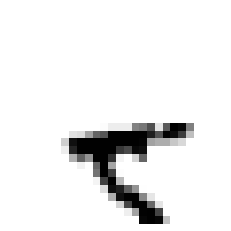

In [43]:
from scipy.ndimage import shift
some_digit = X[0]
im = some_digit.reshape(28, 28)
new_im = shift(im, [10, 0], cval=0)

plt.imshow(new_im, cmap="binary")
plt.axis("off")
plt.show()

As with other exercises, actually running the classification is taking a while. If I shifted each of the images by one pixel in all directions, that would give 5x the original number of samples and would improve performance. Not doing for time.

## 3. Tackle the Titanic dataset
www.kaggle.com/c/titanic

Also a great notebook here: https://www.kaggle.com/startupsci/titanic-data-science-solutions

In [124]:
import os
TITANIC_PATH = os.path.join("datasets", "titanic")
train_df = pd.read_csv(os.path.join(TITANIC_PATH, "train.csv"))
test_df = pd.read_csv(os.path.join(TITANIC_PATH, "test.csv"))

In [47]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [48]:
# numerical attributes only
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


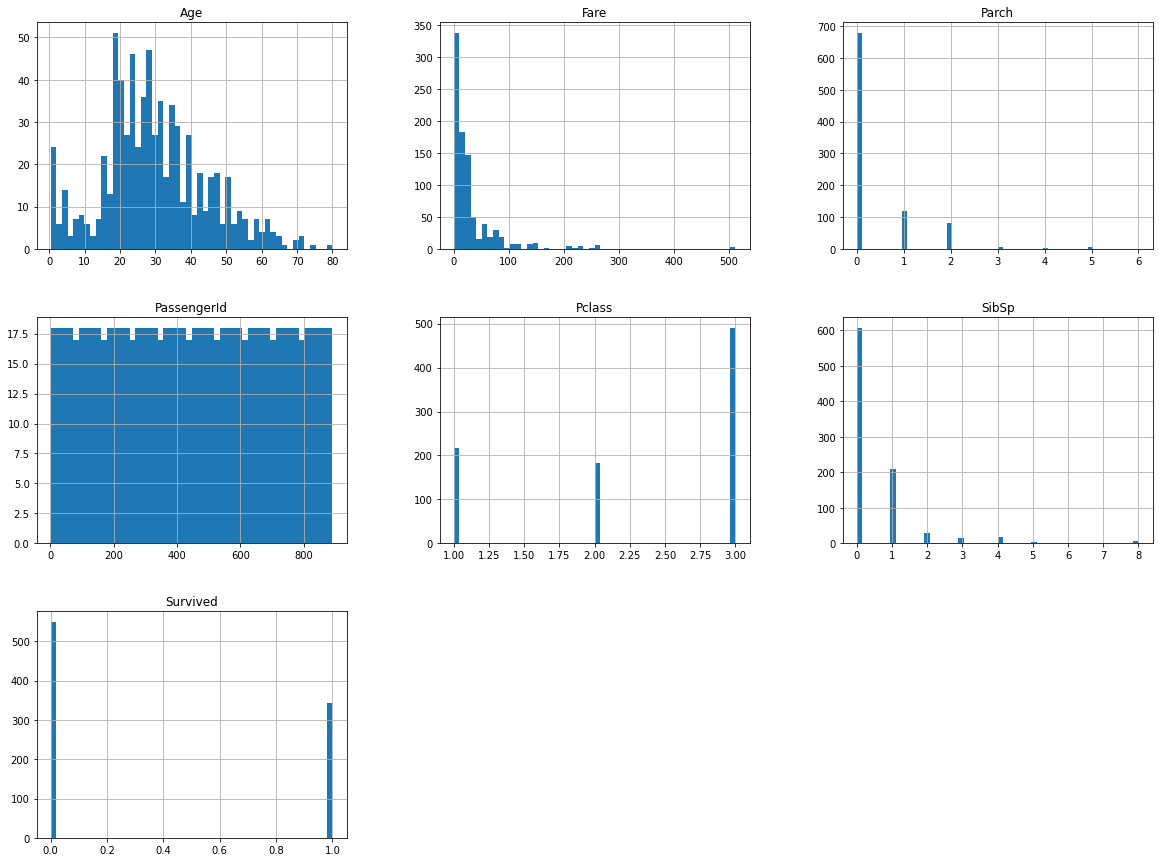

In [49]:
# numerical attributes only
%matplotlib inline
import matplotlib.pyplot as plt
train_df.hist(bins=50, figsize=(20,15))
plt.show()

based on initial look, attributes that likely matter in determining "survived" will not include PassengerID, Name, and Ticket. There may be some info hiding in the ticket attribute, but for now focus elsewhere.

1-hot encode these categorical attributes: sex, cabin, embarked

1-hot encode these numerical attributes: Pclass

In [125]:
num = train_df[["Age", "Fare", "Parch", "SibSp"]]

In [126]:
y_train = train_df["Survived"]

In [60]:
train_df["Sex"].describe()

count      891
unique       2
top       male
freq       577
Name: Sex, dtype: object

In [62]:
train_df["Cabin"].describe()

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

In [63]:
train_df["Embarked"].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [65]:
train_df["Pclass"].astype(str)

0      3
1      1
2      3
3      1
4      3
      ..
886    2
887    1
888    3
889    1
890    3
Name: Pclass, Length: 891, dtype: object

In [127]:
cat = train_df[["Pclass", "Sex", "Cabin", "Embarked"]]

In [75]:
cat.isna().sum()

Pclass        0
Sex           0
Cabin       687
Embarked      2
dtype: int64

^ nulls in Cabin and Embarked! Drop these columns for now. Could try to replace NaNs with other values, but probably not worth for these categories

In [128]:
cat = cat.drop(columns=['Cabin', 'Embarked'])

In [129]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
cat_1_hot = encoder.fit_transform(cat)

In [130]:
encoder.categories_

[array([1, 2, 3]), array(['female', 'male'], dtype=object)]

In [131]:
cat_1_hot

<891x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1782 stored elements in Compressed Sparse Row format>

In [132]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('std_scaler', StandardScaler())
])

In [163]:
from sklearn.compose import ColumnTransformer, make_column_transformer

train_df["Pclass"].astype(str)

num_attribs = ["Age", "Fare", "Parch", "SibSp"]
cat_attribs = ["Pclass", "Sex"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

train_prepared = full_pipeline.fit_transform(train_df)

In [150]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
cross_val_score(sgd_clf, train_prepared, y_train, cv=5, scoring="accuracy")

array([0.73184358, 0.70224719, 0.71348315, 0.74719101, 0.79775281])

In [153]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
cross_val_score(sgd_clf, train_prepared, y_train, cv=5, scoring="accuracy")

array([0.72625698, 0.79213483, 0.7752809 , 0.5505618 , 0.78651685])

In [154]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(forest_clf, train_prepared, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[475,  74],
       [ 87, 255]])

To improve score, could engineer some features, etc. to make performance better. See solutions for some ideas
https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb. One suggestion is to make age bucket categories instead of using ages as numerical values; another is to combine (add) SibSp and Parch to get total relatives on board.

Also, the above link shows a nice (and cleaner) pipeline! There's a dataframe selector class made to select only desired columns. FeatureUnion is chosen to combine num and cat pipelines.

## 4. Build a spam classifier